# DC Source Location

[Lindsey Heagy](http://github.com/lheagy)



SimPEG and the implementation for electrical and electromagnetic methods is described in ([Cockett et al., 2015](https://doi.org/10.1016/j.cageo.2015.09.015) and [Heagy et al., 2017](https://arxiv.org/abs/1610.00804)).

In [1]:
import discretize
from discretize import utils
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.lines as mlines

import ipywidgets
from string import ascii_lowercase

from SimPEG.EM import TDEM
from SimPEG import Utils, Maps

import casingSimulations as casingSim

from pymatsolver import Pardiso

%matplotlib inline

##  Parameters

To examine the impact of replacing the steel cased well with a solid well, I have run a few simulations using SimPEG and simulating the DC resistivity equations using a finite volume approach on a 3D cylindrical mesh.  

The model setup follows . The electrical conductivities used are:
- Casing $1\times 10^6$ S/m
- Air $3\times10^{-7}$ S/m
- Background $3\times10^{-2}$ S/m
- Inside the casing - same as background

In the first example, the well is 200m long. The thickness of the casing is 12mm. Here, we are interested in examining a top casing source, where one electrode is connected to the top of the casing and a return electrode is some radial distance away on the surface. In the following examples, we will put the return electrode a distance of 2x the length of the well (for the first example, it is 400 m away). For datam we measure the radial electric field along a line $90^\circ$ from the source wire, starting from the well and measuring out to a distance of 400m away. 

### Experiments

From the base example, there are 3 that are setup, you can select one by changing the `experiment` variable or setting your own values for `casing_l`, `sigma_back` and `sigma_air`.

In [2]:
simDir = 'DC_target_3D'  # create a simulation directory where results can be saved. 

In [3]:
casing_l = 1000
sigma_back = 1e-1
casing_d = 10e-2 #10cm diameter
casing_t = 1e-2 #1cm thickness

model = casingSim.model.CasingInHalfspace(
    directory=simDir,
    sigma_casing= 5e6,  # conductivity of the casing (S/m)
    sigma_back = sigma_back,  # conductivity of the background (S/m)
    sigma_inside = sigma_back,  # fluid inside the well has same conductivity as the background
    sigma_air = 1e-4,   # conductivity of the air
    casing_d = casing_d-casing_t,  # 10 cm is outer casing diameter
    casing_l = casing_l,
    casing_t = casing_t, 
#     target_radius = target_r,
#     target_z = target_z,
    src_a = np.r_[0., np.pi, -1.25],  # put the A electrode just below the surface
    src_b = np.r_[casing_l/2, np.pi, -1.25] # put the return electrode at a distance of 2 x length of well away
)

# adjust the src_a location so it is connected to well
model.src_a = np.r_[model.casing_r, np.pi, -1.25]  

In [4]:
# Here we print the parameters being used to set up the simulation
model.serialize()

{'__class__': 'CasingInHalfspace',
 'casing_d': 0.09000000000000001,
 'casing_l': 1000.0,
 'casing_t': 0.01,
 'casing_top': 0.0,
 'directory': 'DC_target_3D',
 'filename': 'ModelParameters.json',
 'mur_back': 1.0,
 'mur_casing': 1.0,
 'sigma_air': 0.0001,
 'sigma_back': 0.1,
 'sigma_casing': 5000000.0,
 'sigma_inside': 0.1,
 'src_a': [0.045000000000000005, 3.141592653589793, -1.25],
 'src_b': [500.0, 3.141592653589793, -1.25],
 'surface_z': 0.0,
 'version': '0.0.5'}

In [5]:
print(50*50*25)


62500


In [6]:
sigma_target = sigma_back
target_r = np.r_[0, 25.]
target_z = np.r_[-925., -900.]
target_y = np.r_[-25, 25]

## Mesh

Here we set up a 3D cylindrical mesh, discretizing in $x$, $\theta$ and $z$. 

To discretize in x, we start by defining the finest region of the mesh, ensuring that we have 4 cells across the thickness of the casing. From there, we expand the cell sizes until we reach the second uniform cell size we want to model at (`csx2`). We then use a constant cell spacing of `csx2` until we have meshed out to the end of the domain in which we want to examine data (`domainx2`). Beyond that, we add padding cells to *"infinity"*

In [7]:
# parameters defining the core region of the mesh
# note that the finest re
csx2 = 25.  # cell size in the x-direction in the second uniform region of the mesh (where we measure data)
csz = 2.5  # cell size in the z-direction 
domainx2 = 1000  # go out 500m from the well

# padding parameters
npadx, npadz = 8, 15  # number of padding cells
pfx2 = 1.4  # expansion factor for the padding to infinity in the x-direction
pfz = 1.4

# discretization in theta
# hy = utils.meshTensor([(1, 2, -1.5), (1, 3), (1, 2, 1.5)])
hy = np.ones(16)
# hy = np.r_[hy, hy]
hy = hy*2*np.pi / hy.sum()

# set up a mesh generator which will build a mesh based on the provided parameters
# and casing geometry
cylMeshGen = casingSim.CasingMeshGenerator(
    directory=simDir,  # directory where we can save things
    modelParameters=model,  # casing parameters
    npadx=npadx,  # number of padding cells in the x-direction
    npadz=npadz,  # number of padding cells in the z-direction
    domain_x=domainx2,  # extent of the second uniform region of the mesh 
    hy=hy,   # cell spacings in the 
    csx1=model.casing_t/4.,  # use at least 4 cells per across the thickness of the casing
    csx2=csx2,  # second core cell size
    csz=csz,  # cell size in the z-direction
    pfx1=1.2, 
    pfx2=pfx2,  # padding factor to "infinity"
    pfz=pfz  # padding factor to "infinity" for the z-direction
)

/anaconda3/lib/python3.6/site-packages/matplotlib/projections/polar.py:58: RuntimeWarning: invalid value encountered in less
  mask = r < 0


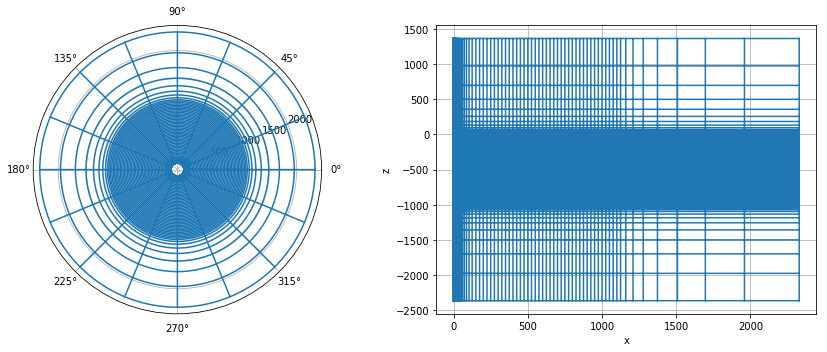

In [8]:
cylMeshGen.mesh.plotGrid()

In [9]:
src_theta = np.pi + hy[0]/2.

model.src_a[1] = src_theta
model.src_b[1] = src_theta

(0.0, 3000.0)

/anaconda3/lib/python3.6/site-packages/matplotlib/projections/polar.py:58: RuntimeWarning: invalid value encountered in less
  mask = r < 0


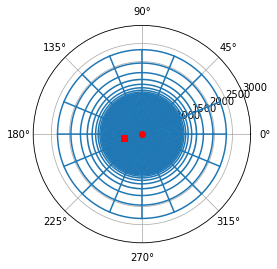

In [10]:
# Plot the source location

ax = plt.subplot(111, projection='polar')
cylMeshGen.mesh.plotGrid(ax=ax, slice='z')
ax.plot(model.src_a[1], model.src_a[0], 'ro')
ax.plot(model.src_b[1], model.src_b[0], 'rs')
ax.set_ylim([0., 3*model.casing_l])

In [11]:
model_names = ["model"]
modelDict = {
    'model': model
}

In [12]:
# Assign physical properties on the mesh
physpropsDict = {
    key: casingSim.model.PhysicalProperties(cylMeshGen, modelDict[key]) 
    for key in model_names
}

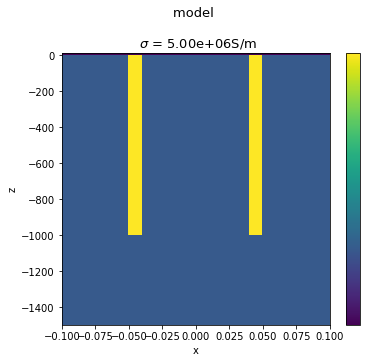

In [13]:
# Plot the models
xlim = 0.1*np.r_[-1, 1]  # x-limits in meters
zlim = np.r_[-1.5*model.casing_l, 10.]  # z-limits in meters. (z-positive up)
# zlim = np.r_[-1000, -800]

fig, ax = plt.subplots(1, len(model_names), figsize=(6*len(model_names), 5))
if len(model_names) == 1:
    ax=[ax]
    
for a, title in zip(ax, model_names):
    pp = physpropsDict[title]
    pp.plot_sigma(
        ax=a, 
        pcolorOpts={'norm':LogNorm()}  # plot on a log-scale
    )
    a.set_title('{} \n\n $\sigma$ = {:1.2e}S/m'.format(title, pp.modelParameters.sigma_casing), fontsize=13)
#     cylMeshGen.mesh.plotGrid(ax=a, slice='theta') # uncomment to plot the mesh on top of this
    a.set_xlim(xlim)
    a.set_ylim(zlim)

## Source locations

In [14]:
# Set up 4 sources, top casing, top & not coupled, downhole, downhole not coupled

src_a = np.vstack([
    [model.casing_r, src_theta, -1.25],
    [model.casing_r, src_theta, target_z.mean()],
])

src_b = np.ones((src_a.shape[0],1)) * model.src_b

src_names = [
    "top casing",
    "downhole",
]


## set up a DC simulation

In [15]:
simDict = {}
for title in model_names:
    simDict[title] = casingSim.run.SimulationDC(
        modelParameters=modelDict[title], directory=simDir, 
        meshGenerator=cylMeshGen, src_a=src_a, src_b=src_b
    )


Homogeneous Dirichlet is the natural BC for this CC discretization.


In [16]:
%%time
fieldsDict = {}
for title in model_names:
    print('--- Running {} ---'.format(title))
    fieldsDict[title] = simDict[title].run()
    print('\n')

--- Running model ---
Validating parameters...
      max x: 2328.8154239999994, min z: -2364.970836130856, max z: 1364.9708361308562, nC: 844800
Saved DC_target_3D/simulationParameters.json
Starting SimulationDC
Using <class 'pymatsolver.direct.Pardiso'> Solver
   ... Done. Elapsed time : 74.59022903442383


CPU times: user 1min 41s, sys: 6.3 s, total: 1min 48s
Wall time: 1min 14s


## Plot Results

Here we plot the radial electric field along a line $90^{\circ}$ from the source. 

In [17]:
viewer = casingSim.FieldsViewer(
    sim_dict=simDict, fields_dict=fieldsDict, model_keys=model_names
)

In [18]:
viewer.widget_cross_section()

interactive(children=(FloatText(value=0.1, description='max_r'), FloatText(value=-10.0, description='min_depth'), FloatText(value=1250.0, description='max_depth'), FloatText(value=0.0, description='clim_min'), FloatText(value=0.0, description='clim_max'), ToggleButtons(description='model_key', options=('model', 'all'), value='model'), ToggleButtons(description='view', options=('sigma', 'e', 'j', 'phi', 'charge', 'charge_density'), value='sigma'), IntSlider(value=0, description='src_ind', max=1), IntSlider(value=0, description='theta_ind', max=15), Checkbox(value=False, description='show_mesh'), Checkbox(value=False, description='use_aspect'), Checkbox(value=True, description='casing_outline'), Output()), _dom_classes=('widget-interact',))

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>>

In [19]:
hy[0]/2

0.19634954084936207

In [20]:
viewer.widget_depth_slice()

interactive(children=(FloatText(value=1000.0, description='max_r'), FloatText(value=0.0, description='clim_min'), FloatText(value=0.0, description='clim_max'), ToggleButtons(description='model_key', options=('model', 'all'), value='model'), ToggleButtons(description='view', options=('sigma', 'e', 'j', 'phi', 'charge', 'charge_density'), value='sigma'), IntSlider(value=220, description='z_ind', max=439), IntSlider(value=0, description='src_ind', max=1), Checkbox(value=False, description='use_aspect'), Checkbox(value=False, description='rotate'), IntSlider(value=10, description='k', max=50), FloatText(value=0.0, description='theta_shift'), Output()), _dom_classes=('widget-interact',))

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>>

In [21]:
mesh = cylMeshGen.mesh

In [22]:
np.diff(target_z)

array([25.])

In [23]:
horizontal_extent = 2200
csh = 5

mesh_cart = discretize.TensorMesh(
    [ 
        csh*np.ones(int(horizontal_extent/csh)), 
        csh*np.ones(int(horizontal_extent/csh)), 
        csz*np.ones(int((target_z.max() - target_z.min())/csz))
#         np.r_[csz]
    ],
    x0 = np.r_[-horizontal_extent/2., -horizontal_extent/2., target_z.min()]
)

In [24]:
mesh = cylMeshGen.mesh

In [25]:
z_start = np.where((mesh.vectorCCz - mesh_cart.vectorCCz[0]) == np.min(np.abs(mesh.vectorCCz - mesh_cart.vectorCCz[0])))[0][0]

In [26]:
from scipy.spatial import cKDTree

In [27]:
theta_shift=mesh.hy[0]/2
CCcart = mesh.cartesianGrid('CC', theta_shift=theta_shift)
tree = cKDTree(CCcart[:mesh.vnC[:2].prod(),:2])
d, ii = tree.query(mesh_cart.gridCC[:mesh_cart.vnC[:2].prod(), :2], k=10)

weights = 1./d
weights = discretize.utils.sdiag(1./weights.sum(1))*weights

In [35]:
key = "model"
srcList = simDict[key].survey.srcList
e_cart = np.zeros((mesh_cart.nC*3, len(srcList)))

for src_ind, src in enumerate(srcList):
    gridCC = mesh.gridCC.copy() - theta_shift
    e_cyl = discretize.utils.cyl2cart(
        gridCC, (mesh.aveF2CCV * fieldsDict[key][src, 'e']).reshape(mesh.gridCC.shape, order="F")
    )
    
    e_cyl_dict = {key: e_cyl[:, i].reshape(mesh.vnC, order="F") for i, key in enumerate(["x", "y", "z"])}
    
    e_cart_dict = {"x":[], "y":[], "z":[], }
    
    for z_ind in range(mesh_cart.vnC[2]):
        for dim in e_cart_dict.keys():
#             z_cyl_ind = discretize.utils.closestPoints()
            e_cart_dict[dim] += [(discretize.utils.mkvc(e_cyl_dict[dim][:, :, z_start + z_ind])[ii] * weights).sum(1)]
    
    e_cart[:, src_ind] = np.hstack(
        [np.hstack(e_cart_dict[dim]) for dim in e_cart_dict.keys()]
    )
        
    
    

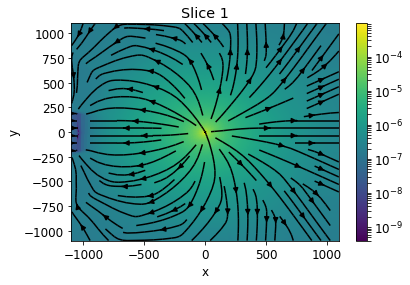

In [36]:
plt.colorbar(mesh_cart.plotSlice(
    e_cart[:, 1], view="vec", vType="CCv",
    pcolorOpts={"norm":LogNorm()}, 
    normal='Z', ind=1
)[0])

In [37]:
models = {
    0: [np.r_[0, -50], np.r_[-25, 25], target_z],
    90: [np.r_[-25., 25.], np.r_[0., 50], target_z],
    180: [np.r_[0., 50], np.r_[-25., 25.], target_z]
}

offsets = np.arange(5., 500., 10.)

def add_offset(key, offset):
    val = models[key ]
    return [
        offset*np.cos(key/180*np.pi + np.pi) + val[0], 
        offset*np.sin(key/180*np.pi) + val[1],
        val[2]
    ]

In [38]:
from matplotlib import rcParams
rcParams['font.size'] = 12

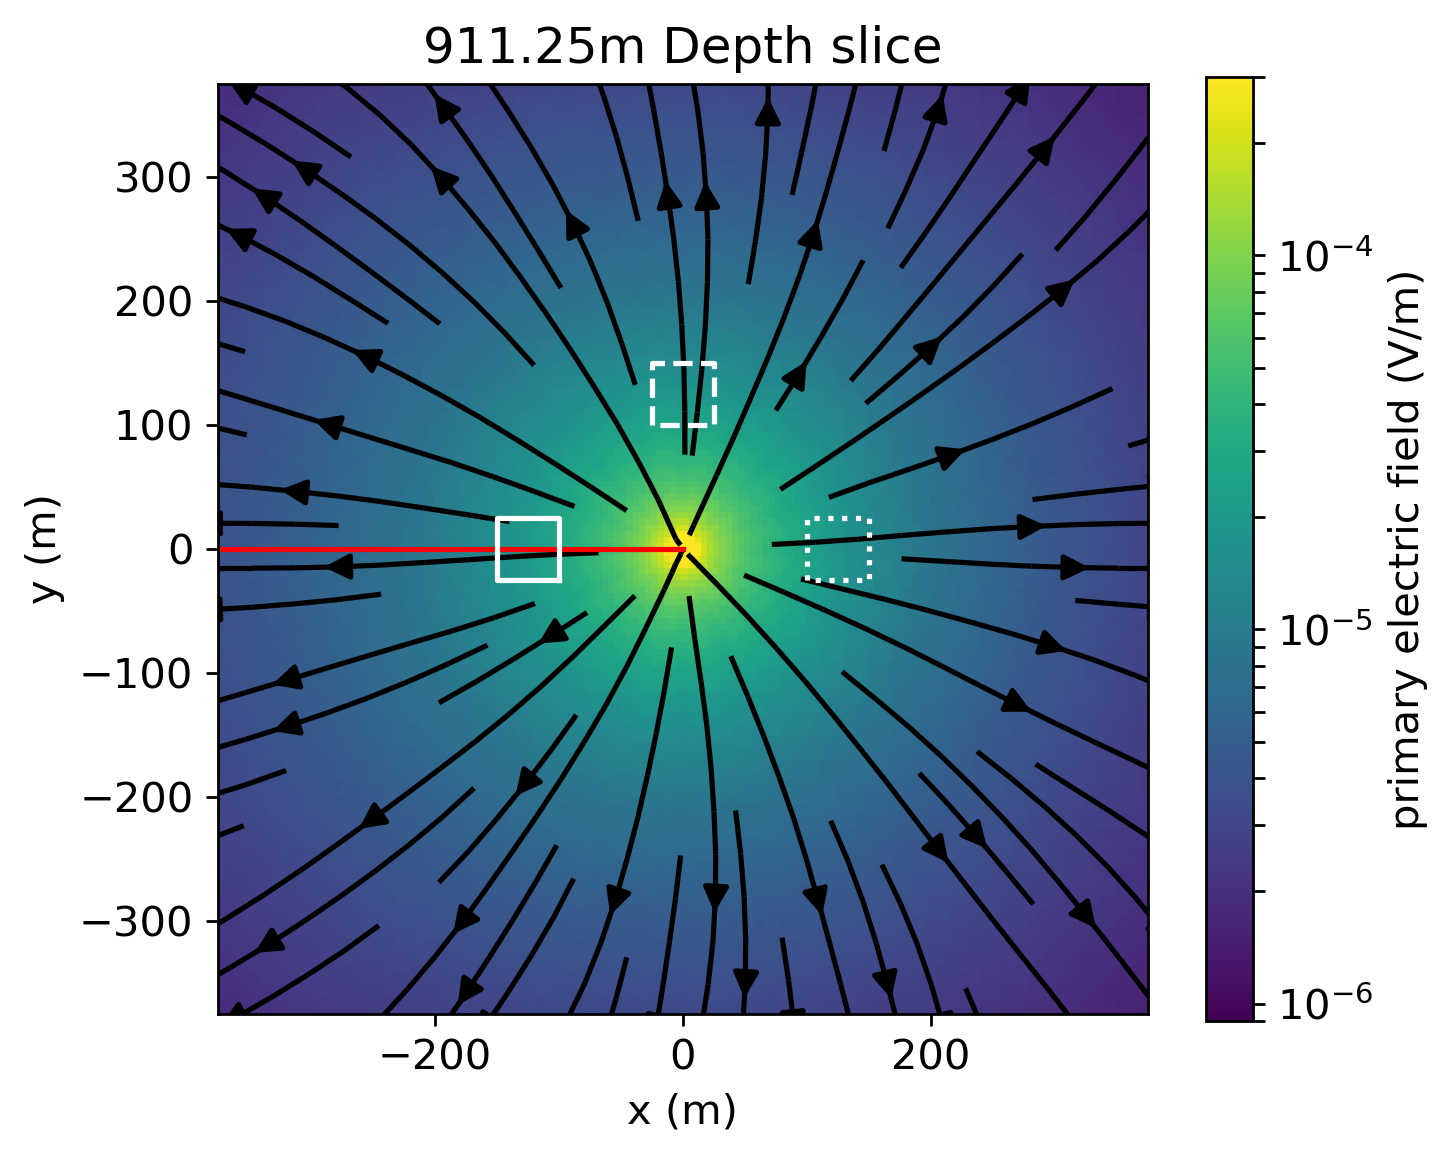

In [39]:
fig, ax = plt.subplots(1, 1, figsize = (6, 5), dpi=250) 
xlim = 375
zind = 5
offset = 100

cb = plt.colorbar(mesh_cart.plotSlice(
    e_cart[:, 1], view="vec", vType="CCv",
    pcolorOpts={"norm":LogNorm()}, 
    normal='Z', ax=ax, streamOpts={'arrowsize':1.5, "color":"k"},
    ind = zind, clim=np.r_[9e-7, 3e-4], range_x=1.4*xlim*np.r_[-1, 1], range_y=1.4*xlim*np.r_[-1, 1]
)[0], ax=ax)

ax.set_xlim(xlim*np.r_[-1., 1.])
ax.set_ylim(xlim*np.r_[-1., 1.])
ax.set_title("{:1.2f}m Depth slice".format(-mesh_cart.vectorCCz[zind]))
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")

cb.set_label("primary electric field (V/m)")

ax.plot(np.r_[-xlim, 0], [0, 0], 'r-')

for key, l in zip(models.keys(), ['-', '--', ':']):
    m = add_offset(key, offset)
    x = np.hstack([m[0][0], m[0], m[0][1], m[0][1], m[0][0]])
    y = np.hstack([m[1], m[1][1], m[1][1], m[1][0], m[1][0]])
    ax.plot(x, y, 'w'+l)



ax.set_aspect(1)
fig.savefig('primary_3D', bbox_inches="tight")

In [40]:
def excitation(target_x, target_y, target_z, target_sigma, src_ind=0):
    
    e = e_cart[:, src_ind]
    e = [e[i*mesh_cart.nC:(i+1)*mesh_cart.nC] for i in range(3)]

    sigma_sec = target_sigma - modelDict["model"].sigma_back
    
    inds = (
        (mesh_cart.gridCC[:, 0] >= target_x.min()) & (mesh_cart.gridCC[:, 0] <= target_x.max()) &
        (mesh_cart.gridCC[:, 1] >= target_y.min()) & (mesh_cart.gridCC[:, 1] <= target_y.max()) &
        (mesh_cart.gridCC[:, 2] >= target_z.min()) & (mesh_cart.gridCC[:, 2] <= target_z.max())
    )
    
    j = [sigma_sec*ei for ei in e]
    jV = [mesh_cart.vol*ji for ji in j]
    J = [np.sum(ji[inds]) for ji in jV]

    return np.sqrt(np.sum([Ji**2 for Ji in J]))

In [41]:
for offset in [25., 50., 100., 200., 400., 800.]:
    print(
        "{}: {:1.2e}".format(
            offset, 
            excitation(offset + np.r_[0., 50.], np.r_[-25., 25], target_z, 1e1, src_ind=1)
        )
    )

25.0: 3.79e+01
50.0: 2.38e+01
100.0: 1.20e+01
200.0: 4.59e+00
400.0: 1.49e+00
800.0: 3.86e-01


In [42]:
for offset in [25., 50., 100., 200., 400., 800.]:
    print(
        "{}: {:1.2e}".format(
            offset, 
            excitation(np.r_[-25., 25.], offset + np.r_[0., 50], target_z, 1e1, src_ind=1)
        )
    )

25.0: 3.83e+01
50.0: 2.41e+01
100.0: 1.23e+01
200.0: 4.80e+00
400.0: 1.58e+00
800.0: 3.78e-01


In [43]:
for offset in [25., 50., 100., 200., 400., 800.]:
    print(
        "{}: {:1.2e}".format(
            offset, 
            excitation(-offset + np.r_[0., -50.], np.r_[-25., 25], target_z, 1e1, src_ind=1)
        )
    )

25.0: 3.87e+01
50.0: 2.46e+01
100.0: 1.27e+01
200.0: 5.21e+00
400.0: 1.96e+00
800.0: 7.54e-01


In [44]:
target_sigmas = [1e-3, 1e-2, 1e0, 1e1]

model_excitations = {}
nsrcs = len(simDict["model"].survey.srcList)
offsets = np.arange(5, 500, 10)
for key, val in models.items(): 
    excit = {}

    for sig in target_sigmas:
        ex = np.zeros((len(offsets), nsrcs))
        for j in range(nsrcs):
            tmp = []
            for offset in offsets:
                tmp.append(
                    excitation(
                        offset*np.cos(key/180*np.pi + np.pi) + val[0], 
                        offset*np.sin(key/180*np.pi) + val[1],
                        val[2],
                        sig, src_ind=j
                    )
                )
            ex[:, j] = np.hstack(tmp)
        excit[sig] = ex
    model_excitations[key] = excit

In [45]:
from matplotlib import rcParams
rcParams['font.size']  =12



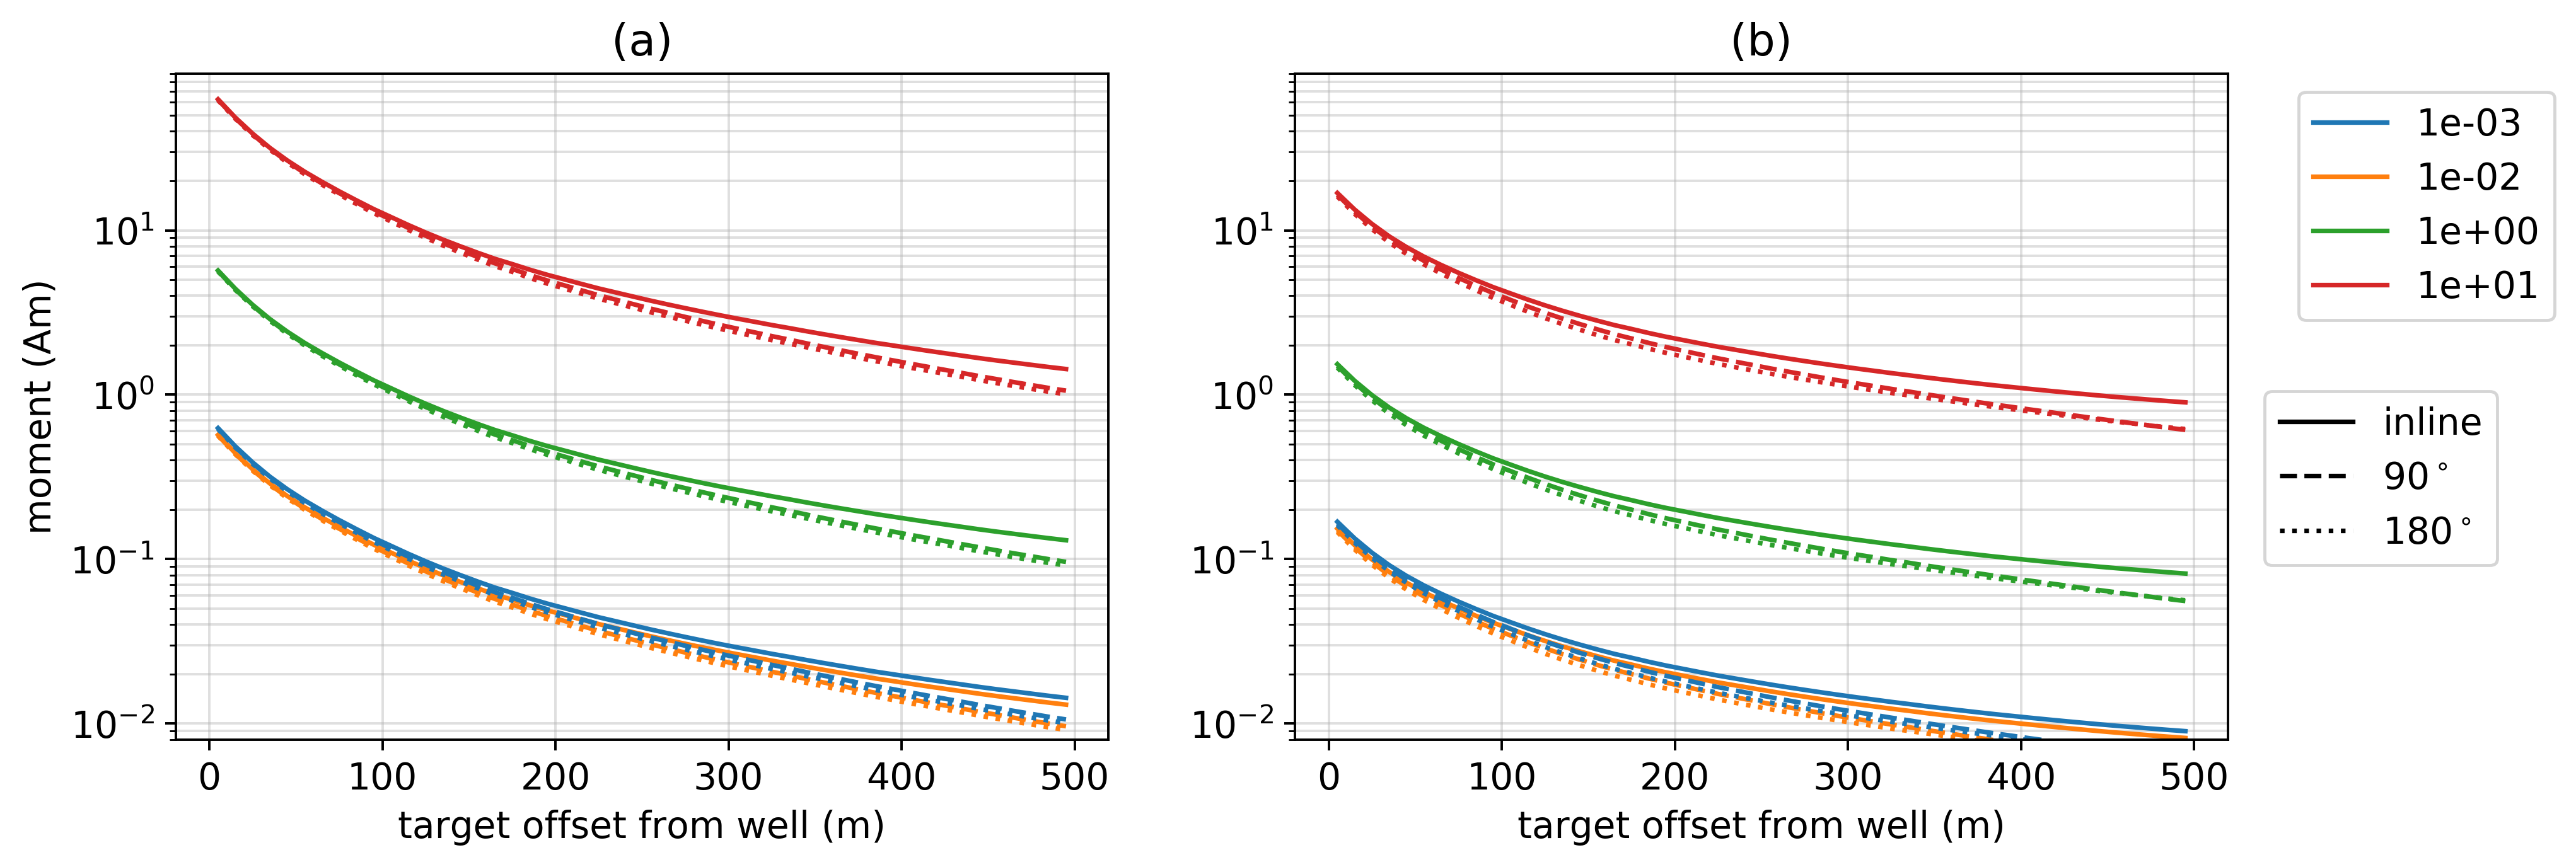

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), dpi=350)

linestyles = dict(zip(models.keys(), ['-', '--', ':']))
# colors = dict(zip(models.keys(), ["C{}".format(i) for i in range(len(models.keys()))]))

for j, src_ind in enumerate([1, 0]): 
    for key, val in models.items():
        ls = linestyles[key]
        for i, sig in enumerate(target_sigmas): 
            ax[j].semilogy(
                offsets, model_excitations[key][sig][:,src_ind], 
                label = "{:1.0e}".format(sig) if ls=="-" else None,
                ls=ls, color = "C{}".format(i)
            )

for i, a in enumerate(ax): 
    a.grid(which='both', alpha=0.4)
    if i == 0: 
        a.set_ylabel("moment (Am)")
    a.set_xlabel("target offset from well (m)")
#     a.legend()
    a.set_title("({})".format(ascii_lowercase[i]))
    a.set_ylim([8e-3, 9e1])

ax[0].legend(bbox_to_anchor=[2.57, 1])
ax[1].legend(
    handles=[
        mlines.Line2D([], [], color='k', label='inline'),
        mlines.Line2D([], [], color='k', linestyle='--', label='$90^\circ$'), 
        mlines.Line2D([], [], color='k', linestyle=':', label='$180^\circ$')
    ], bbox_to_anchor=[1.02, 0.55]
)



fig.savefig("excitation_3D", dpi=350, bbox_inches="tight")

In [ ]:
models

In [47]:
offset = 50
loc = [models[90][0], offset+models[90][1], models[90][2]]
moment = excitation(loc[0], loc[1], loc[2], 10, src_ind=1)
print(moment)

24.142372035713233


In [48]:
loc[1].mean()

75.0

In [49]:
offset+models[90][1]

array([ 50., 100.])

In [50]:
from geoana.em import fdem

In [51]:
e_dipole = fdem.ElectricDipoleWholeSpace(
    current=moment, frequency=0, length=1, 
    location=np.r_[[np.mean(l) for l in loc]], orientation="Y",
    sigma=sigma_back
)

In [52]:
np.r_[[np.mean(l) for l in loc]]

array([   0. ,   75. , -912.5])

In [53]:
y = np.linspace(-2000, 2000.)
xyz = discretize.utils.ndgrid(
    np.r_[0.], y, np.r_[-1.25]
)

In [54]:
e = e_dipole.electric_field(xyz)

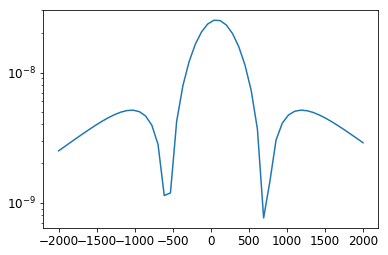

In [55]:
plt.semilogy(y, np.absolute(e[:,1]))

In [56]:
no_casing =  model.copy()
no_casing.sigma_casing = sigma_back
# no_casing.sigma_air = sigma_back
modelDict["no_casing"] = no_casing

In [57]:
e_dipole.current

24.142372035713233

In [58]:
cylMeshGen.mesh.vectorCCx[
    np.absolute((cylMeshGen.mesh.vectorCCx - loc[1][0])) == np.absolute(cylMeshGen.mesh.vectorCCx - loc[1][0]).min()
]

array([46.07453776])

(0.0, 200)

/anaconda3/lib/python3.6/site-packages/matplotlib/projections/polar.py:58: RuntimeWarning: invalid value encountered in less
  mask = r < 0


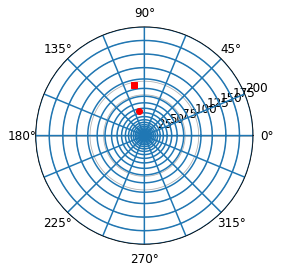

In [59]:
# Plot the source location
src_a_r = cylMeshGen.mesh.vectorCCx[
    np.absolute(cylMeshGen.mesh.vectorCCx - loc[1][0]) == np.absolute(cylMeshGen.mesh.vectorCCx - loc[1][0]).min()
]
src_b_r = cylMeshGen.mesh.vectorCCx[
    np.absolute(cylMeshGen.mesh.vectorCCx - loc[1][1]) == np.absolute(cylMeshGen.mesh.vectorCCx - loc[1][1]).min()
]

src_a = np.r_[src_a_r, np.pi/2. + cylMeshGen.mesh.hy[0]/2., loc[2].mean()]
src_b = np.r_[src_b_r, np.pi/2. + cylMeshGen.mesh.hy[0]/2., loc[2].mean()]

ax = plt.subplot(111, projection='polar')
cylMeshGen.mesh.plotGrid(ax=ax, slice='z')
ax.plot(src_a[1], src_a[0], 'ro')
ax.plot(src_b[1], src_b[0], 'rs')
ax.set_ylim([0., 200])

In [60]:
detectSim = {
    key: casingSim.run.SimulationDC(
        modelParameters=modelDict[key], directory=simDir, 
        meshGenerator=cylMeshGen, src_a=src_a, src_b=src_b
    )
    for key in modelDict.keys()
}

Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.


In [61]:
%%time
detect_fields = {}

for key in detectSim.keys():
    print('--- Running {} ---'.format(key))
    detect_fields[key] = detectSim[key].run(save=False)
    print('\n')

--- Running model ---
Validating parameters...
      max x: 2328.8154239999994, min z: -2364.970836130856, max z: 1364.9708361308562, nC: 844800
Starting SimulationDC
Using <class 'pymatsolver.direct.Pardiso'> Solver
   ... Done. Elapsed time : 72.36214280128479


--- Running no_casing ---
Validating parameters...
      max x: 2328.8154239999994, min z: -2364.970836130856, max z: 1364.9708361308562, nC: 844800
Starting SimulationDC
Using <class 'pymatsolver.direct.Pardiso'> Solver
   ... Done. Elapsed time : 82.24331378936768


CPU times: user 3min 19s, sys: 23 s, total: 3min 42s
Wall time: 2min 34s


In [62]:
src_a

array([  46.07453776,    1.76714587, -912.5       ])

In [63]:
from matplotlib import rcParams
rcParams['font.size'] = 14

/anaconda3/lib/python3.6/site-packages/matplotlib/ticker.py:2206: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


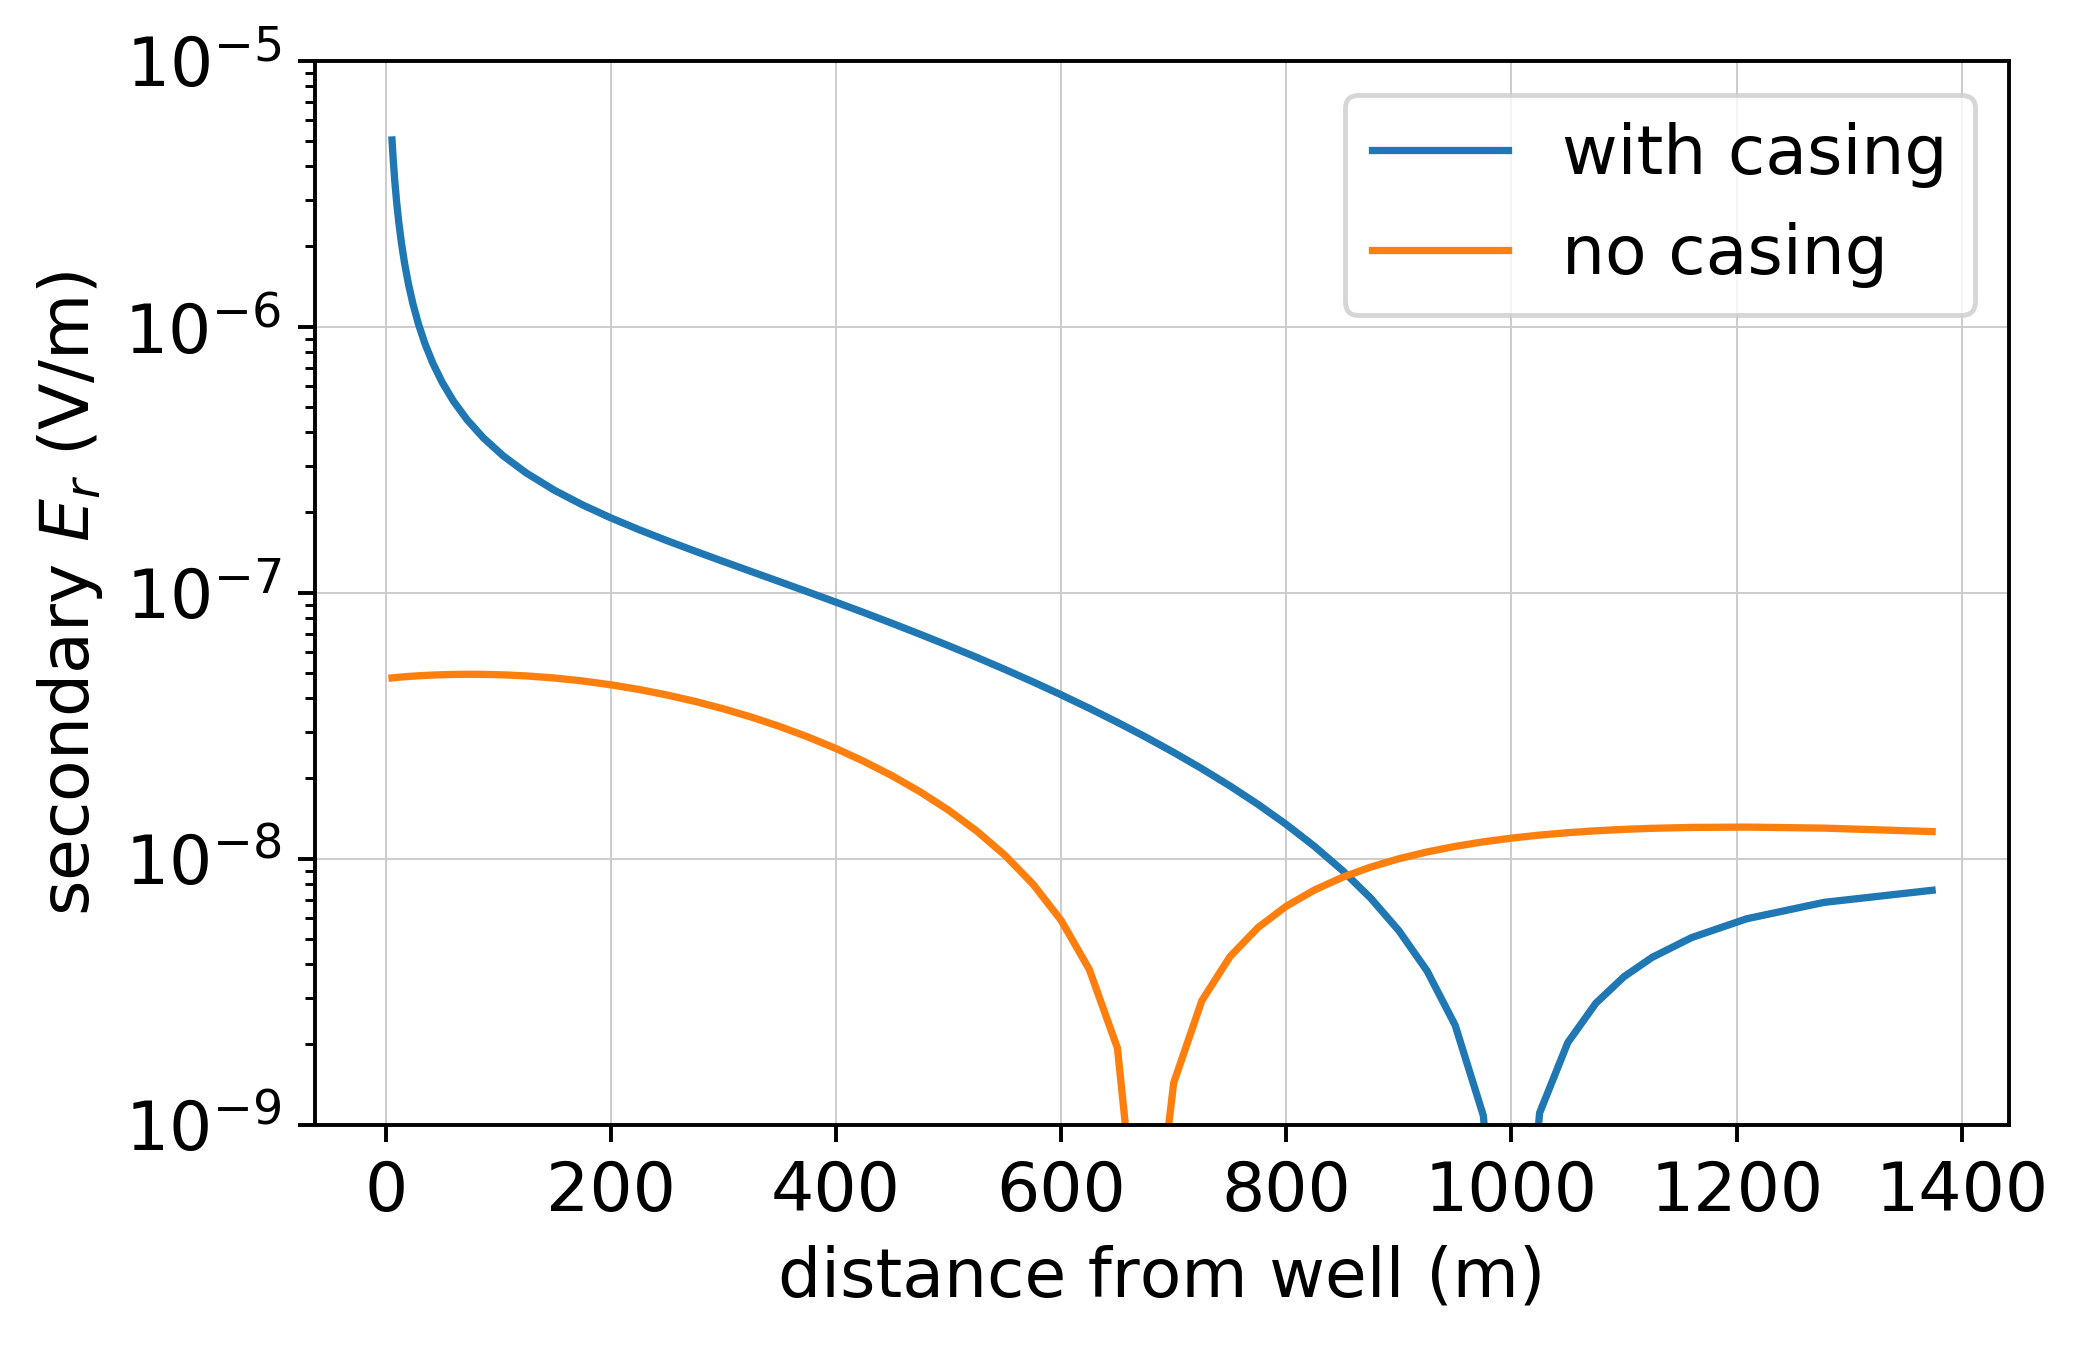

In [64]:
theta_ind = 4
plt_models = detectSim.keys()

fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=350)
ax = [ax]
src_ind=0

xlim = np.r_[5, 1500]

for i, key in enumerate(plt_models): 

    f = detect_fields[key]
    src = detectSim[key].survey.srcList[src_ind]
    xlim = xlim
#     baseline_src = simDict[baseline_key].survey.srcList[src_ind]
#     label="{}".format(key.split("_")[-1] + unit) if key != baseline_key else "baseline"
    label="with casing" if key=="model" else "no casing"

    casingSim.view.plotLinesFx(
        cylMeshGen.mesh,
        field=np.absolute(f[src,'e'])/ (src_b[0] - src_a[0]) * moment,
        pltType='semilogy', ax=ax[0], theta_ind=theta_ind,
        label=label, color_ind=i,
        xlim=xlim
#             color = "k" if key == baseline_key else None
    )

ax[0].set_ylim([1e-9, 1e-5])
ax[0].set_xlabel("distance from well (m)")
ax[0].set_ylabel("secondary $E_r$ (V/m)")

ax[0].legend(bbox_to_anchor=[1, 1])
        


In [65]:
from matplotlib import patches

/anaconda3/lib/python3.6/site-packages/matplotlib/ticker.py:2206: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in true_divide


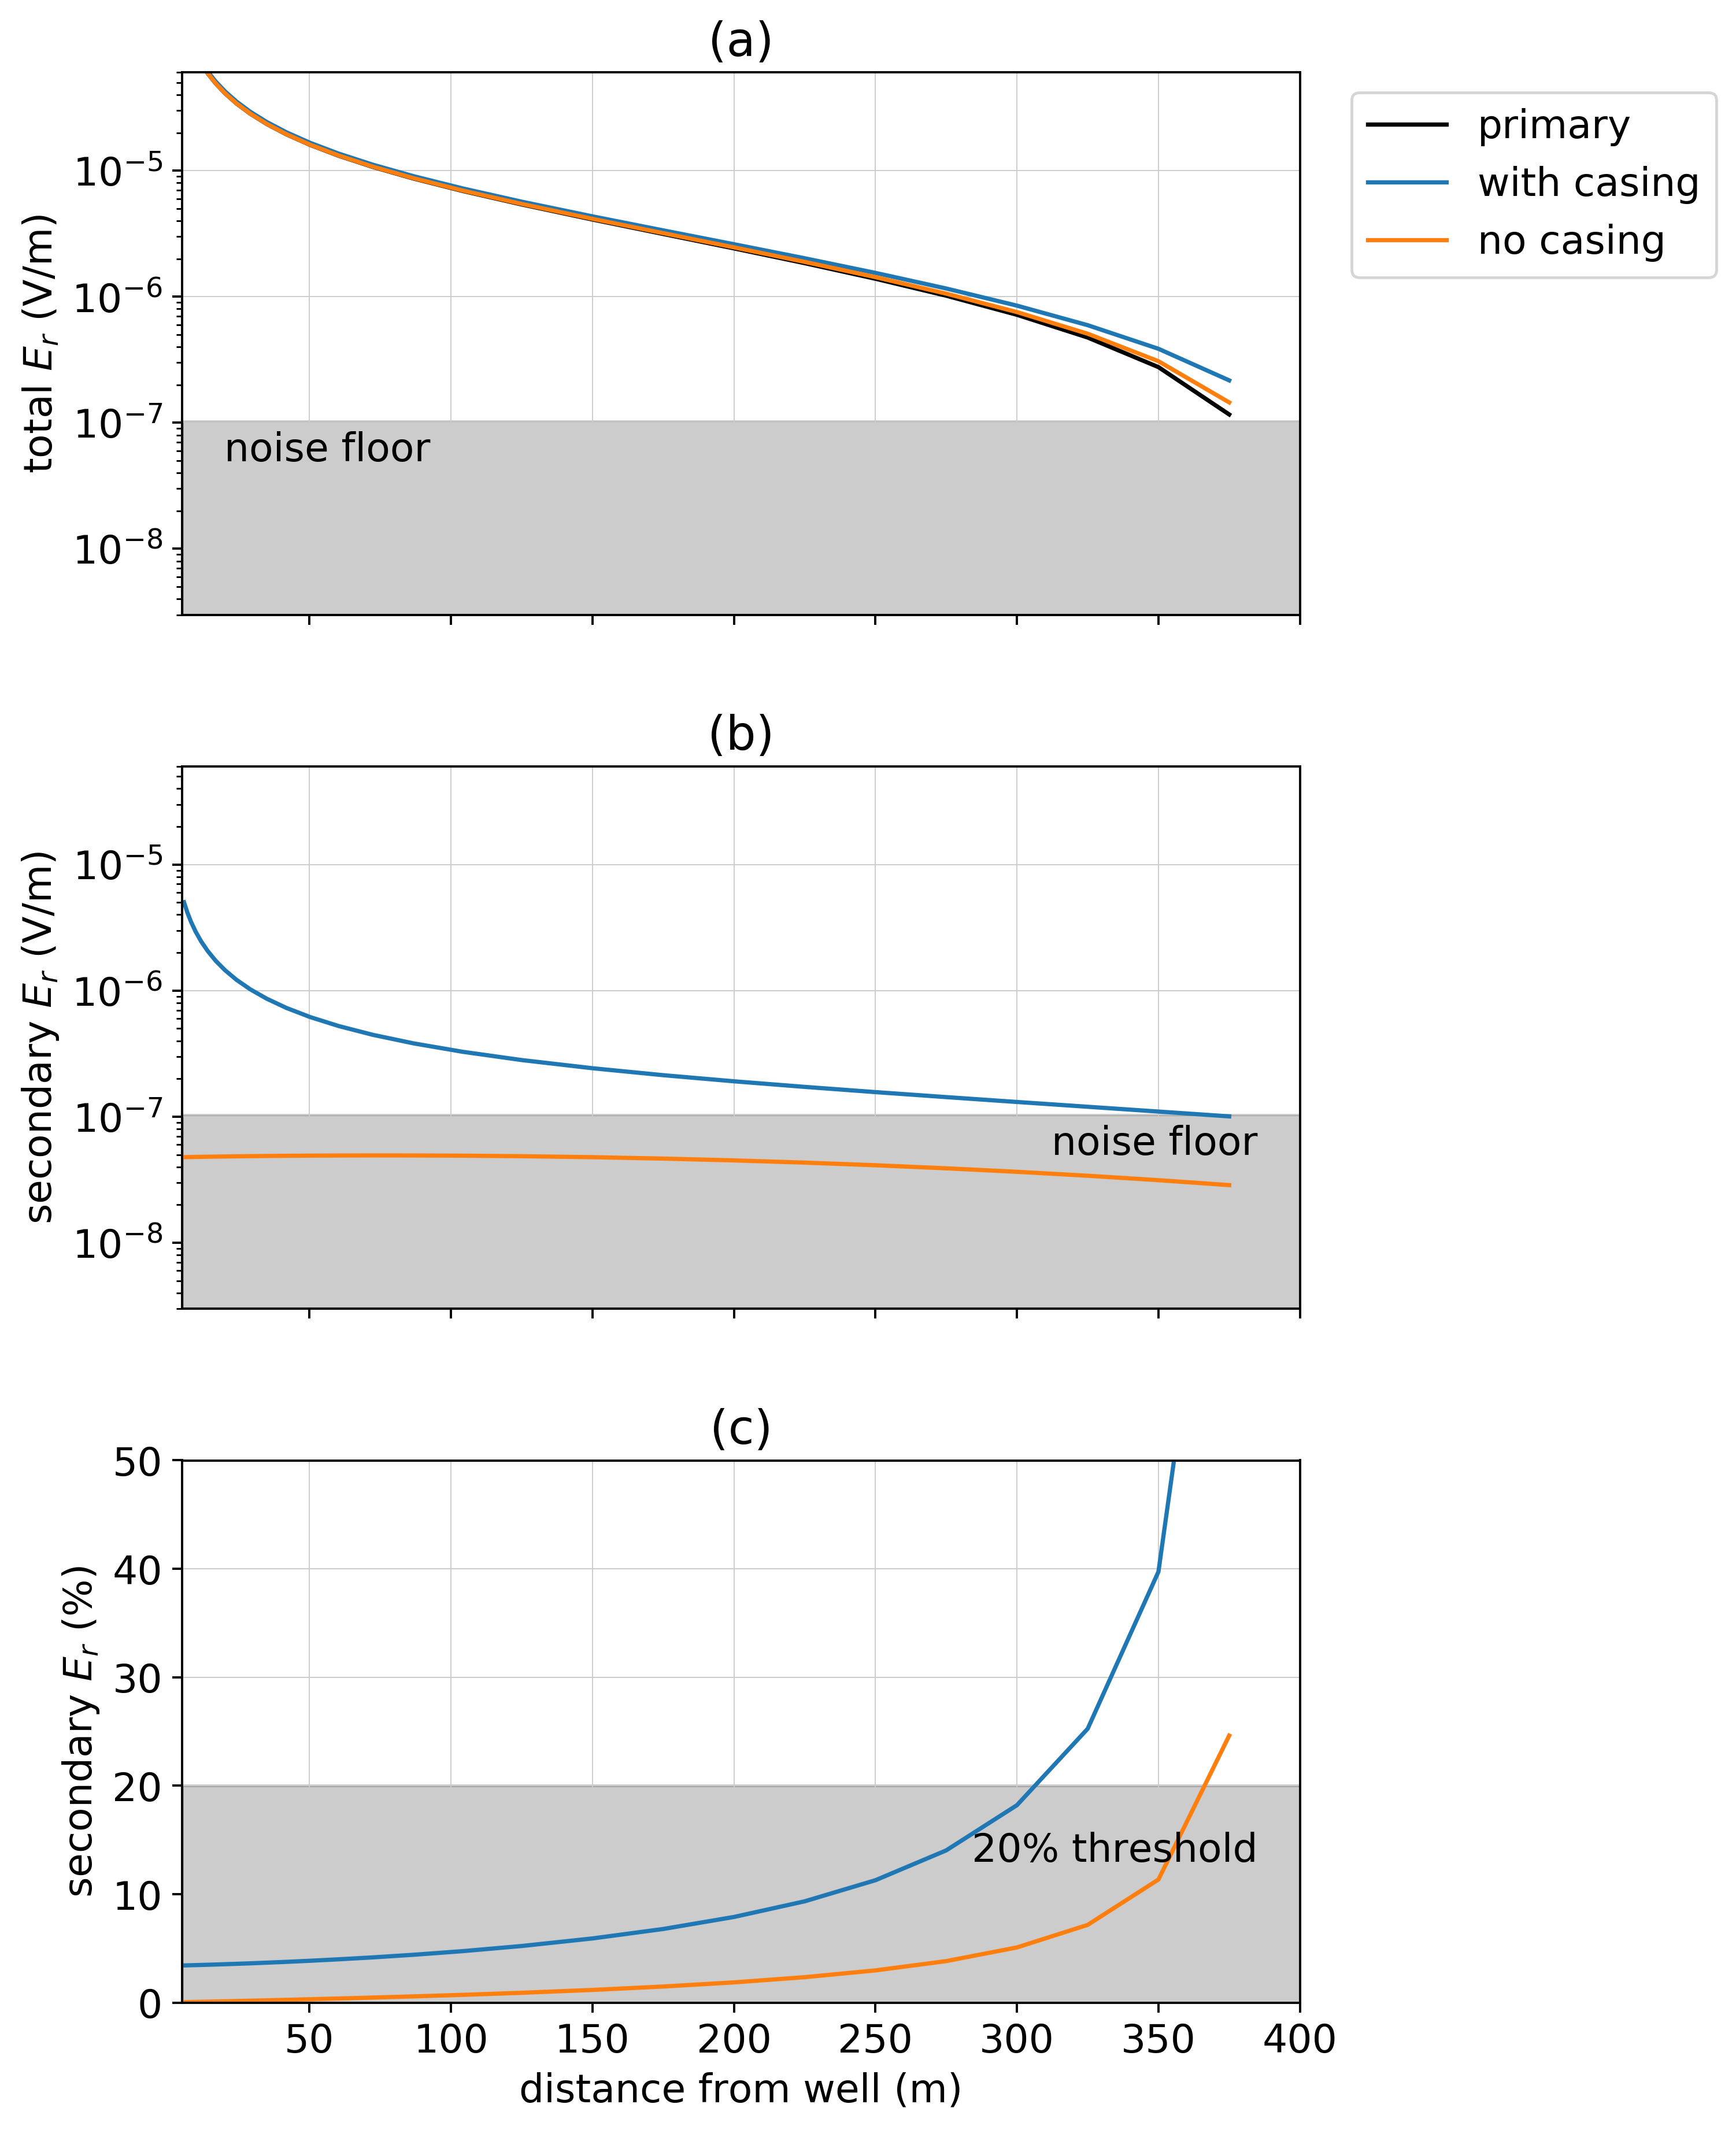

In [70]:
theta_ind = 4
plt_models = detectSim.keys()

fig, ax = plt.subplots(3, 1, figsize = (6.5, 10.5), dpi=350)
# ax = [ax]
src_ind=0

noise_floor = 1e-7
min_percent = 20

xlim = np.r_[5, 400]

ylim = [3e-9, 6e-5]
ylim_percent = [0, 50]

casingSim.view.plotLinesFx(
    cylMeshGen.mesh,
    field= np.absolute(fieldsDict["model"][simDict["model"].survey.srcList[1], 'e']),
    pltType='semilogy', ax=ax[0], theta_ind=theta_ind,
    label="primary", color="k",
    xlim=xlim
#             color = "k" if key == baseline_key else None
)

for i, key in enumerate(plt_models): 

    f = detect_fields[key]
    src = detectSim[key].survey.srcList[src_ind]
    xlim = xlim
#     baseline_src = simDict[baseline_key].survey.srcList[src_ind]
#     label="{}".format(key.split("_")[-1] + unit) if key != baseline_key else "baseline"
    label="with casing" if key=="model" else "no casing"

    casingSim.view.plotLinesFx(
        cylMeshGen.mesh,
        field= np.absolute(f[src,'e']) / (src_b[0] - src_a[0])*moment + np.absolute(fieldsDict["model"][simDict["model"].survey.srcList[1], 'e']),
        pltType='semilogy', ax=ax[0], theta_ind=theta_ind,
        label=label, color_ind=i,
        xlim=xlim
#             color = "k" if key == baseline_key else None
    )
    
    casingSim.view.plotLinesFx(
        cylMeshGen.mesh,
        field=np.absolute(f[src,'e'])/ (src_b[0] - src_a[0])*moment,
        pltType='semilogy', ax=ax[1], theta_ind=theta_ind,
        label=label, color_ind=i,
        xlim=xlim
#             color = "k" if key == baseline_key else None
    )
    
    casingSim.view.plotLinesFx(
        cylMeshGen.mesh,
        field= (np.absolute(f[src,'e']) / (src_b[0] - src_a[0])*moment) / np.absolute(fieldsDict["model"][simDict["model"].survey.srcList[1], 'e']) *100,
        pltType='plot', ax=ax[2], theta_ind=theta_ind,
        label=label, color_ind=i,
        xlim=xlim
#             color = "k" if key == baseline_key else None
    )


for i, a in enumerate(ax):
    a.set_title("({})".format(ascii_lowercase[i]))
        
    a.set_xlim(xlim)
    if i < 2:
        a.set_xlabel('')
        a.set_xticklabels(['']*len(a.get_xticklabels()))
        patch = patches.Rectangle(
            [xlim[0], ylim[0]], xlim[1], noise_floor, color='k', alpha=0.2
        )
        a.add_patch(patch)
        if i == 0: 
            a.text(xlim[0]+15, noise_floor*0.5, "noise floor")
        elif i == 1:
            a.text(xlim[1]-15, noise_floor*0.5, "noise floor", ha="right")
    else:
        patch = patches.Rectangle(
            [xlim[0], ylim_percent[0]], xlim[1], min_percent, color='k', alpha=0.2
        )
        a.add_patch(patch)
        a.text(xlim[1]-15, min_percent-7, "{}% threshold".format(min_percent), ha="right") 

ax[0].set_ylabel('total $E_r$ (V/m)')
ax[1].set_ylabel('secondary $E_r$ (V/m)')
ax[2].set_ylabel('secondary $E_r$ (%)')

ax[0].set_ylim(ylim)
ax[1].set_ylim(ylim)
ax[2].set_ylim (ylim_percent)  
ax[0].legend(bbox_to_anchor=(1.39, 1))

fig.savefig("detectability_dipole", bbox_inches="tight")


In [67]:
viewer = casingSim.FieldsViewer(
    sim_dict=detectSim, 
    fields_dict=detect_fields, 
    model_keys=["model", "no_casing"], primary_key="no_casing"
)

In [68]:
viewer.widget_cross_section()

interactive(children=(FloatText(value=0.1, description='max_r'), FloatText(value=-10.0, description='min_depth'), FloatText(value=1250.0, description='max_depth'), FloatText(value=0.0, description='clim_min'), FloatText(value=0.0, description='clim_max'), ToggleButtons(description='model_key', options=('model', 'no_casing', 'all'), value='model'), ToggleButtons(description='view', options=('sigma', 'e', 'j', 'phi', 'charge', 'charge_density'), value='sigma'), ToggleButtons(description='prim_sec', options=('total', 'primary', 'secondary', 'percent'), value='total'), IntSlider(value=0, description='theta_ind', max=15), Checkbox(value=False, description='show_mesh'), Checkbox(value=False, description='use_aspect'), Checkbox(value=True, description='casing_outline'), Output()), _dom_classes=('widget-interact',))

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>>

# Primary-Secondary for one of the models

In [ ]:
sigma_target = 1
target_loc = models[90]
offset = 100

target_loc[1] = target_loc[1] + offset

In [ ]:
csx = 25
ncx = int(1000/csx) + 1
pfx = 1.3
npadx = 10

csz = csx
ncz = int(1000/csz)
npadz = 10
pfx = 1.3

cart_mesh = discretize.TensorMesh([
    [(csx, npadx, -pfx), (csx, ncx), (csx, npadx,pfx)],
    [(csx, npadx, -pfx), (csx, ncx), (csx, npadx,pfx)],
    [(csz, npadz, -pfz), (csz, ncz), (csz, npadz,pfz)]
])

In [ ]:
cart_mesh.x0 = [-cart_mesh.hx.sum()/2., -cart_mesh.hx.sum()/2., -cart_mesh.hz[:npadz+ncz].sum()]

In [ ]:
target_inds = (
    (cart_mesh.gridCC[:, 0] >= target_loc[0].min()) & (cart_mesh.gridCC[:, 0] <= target_loc[0].max()) &
    (cart_mesh.gridCC[:, 1] >= target_loc[1].min()) & (cart_mesh.gridCC[:, 1] <= target_loc[1].max()) &
    (cart_mesh.gridCC[:, 2] >= target_loc[2].min()) & (cart_mesh.gridCC[:, 2] <= target_loc[2].max())
)

In [ ]:
target_inds.nonzero()

In [ ]:
casing_inds = (
    (cart_mesh.gridCC[:,0] < csx/2.) & (cart_mesh.gridCC[:,0] > -csx/2.) &
    (cart_mesh.gridCC[:,1] < csx/2.) & (cart_mesh.gridCC[:,1] > -csx/2.) &
    (cart_mesh.gridCC[:,2] < 0.) & (cart_mesh.gridCC[:,2] > -model.casing_l) 
)

In [ ]:
casing_sig = model.sigma_casing * (np.pi * (model.casing_b**2 - model.casing_a**2)) / csx**2

In [ ]:
# assign the conductivity model
sigma_cart = model.sigma_air * np.ones(cart_mesh.nC)
sigma_cart[cart_mesh.gridCC[:,2] < 0] = model.sigma_back
# sigma_cart[casing_inds] = casing_sig
sigma_primary = sigma_cart.copy()

sigma_cart[target_inds] = sigma_target


In [ ]:
def plotme(ind):
    fig, ax = plt.subplots(1, 1)
    plt.colorbar(cart_mesh.plotSlice(
        sigma_cart, normal="Z", ax=ax, pcolorOpts={'norm':LogNorm()}, ind=ind, grid=True)[0], ax=ax
    )
    ax.set_xlim([-500, 500])
    ax.set_ylim([-500, 500])
    ax.set_title("z = {:1.1e}".format(cart_mesh.vectorCCz[ind]))
    
    plt.show()

ipywidgets.interact(
    plotme, ind=ipywidgets.IntSlider(min=0, max=cart_mesh.vnC[2], value=13)
)

In [ ]:
def plotme(ind):
    fig, ax = plt.subplots(1, 1)
    plt.colorbar(cart_mesh.plotSlice(sigma_cart, normal="Y", ax=ax, pcolorOpts={'norm':LogNorm()}, ind=ind)[0], ax=ax)
    ax.set_xlim([-500, 500])
    ax.set_ylim([-1100, 25])
    ax.set_title("y = {:1.1e}".format(cart_mesh.vectorCCy[ind]))
    plt.show()

ipywidgets.interact(
    plotme, ind=ipywidgets.IntSlider(min=0, max=cart_mesh.vnC[1], value=cart_mesh.vnC[1]/2)
)

In [ ]:
theta_shift=mesh.hy[0]/2
CCcart = mesh.cartesianGrid('CC', theta_shift=theta_shift)
tree = cKDTree(CCcart)
d, ii = tree.query(cart_mesh.gridCC, k=20)

weights = 1./d
weights = discretize.utils.sdiag(1./weights.sum(1))*weights

In [ ]:
phi_primary = (discretize.utils.mkvc(fieldsDict['model'][srcList[1], 'phi'])[ii] * weights).sum(1)

In [ ]:
cart_mesh.nC

In [ ]:
phi_primary.shape

In [ ]:
def plotme(ind):
    fig, ax = plt.subplots(1, 1)
    plt.colorbar(cart_mesh.plotSlice(phi_primary, normal="Z", ax=ax, ind=ind)[0], ax=ax)
#     ax.set_xlim([-500, 500])
#     ax.set_ylim([-500, 500])
    ax.set_title("z = {:1.1e}".format(cart_mesh.vectorCCz[ind]))
    plt.show()

ipywidgets.interact(
    plotme, ind=ipywidgets.IntSlider(min=0, max=cart_mesh.vnC[2], value=13.)
)

In [ ]:
from SimPEG import DC, Maps

In [ ]:
prob = DC.Problem3D_CC(cart_mesh, sigmaMap=Maps.IdentityMap(cart_mesh), bc_type='Dirichlet')
prob.model = sigma_cart

In [ ]:
D = cart_mesh.faceDiv
MfRhoPrimaryI = cart_mesh.getFaceInnerProduct(1./sigma_primary, invMat=True)
MfRhoI = cart_mesh.getFaceInnerProduct(1./sigma_cart, invMat=True)
src_term = -prob.Div * ((MfRhoI - MfRhoPrimaryI) * (prob.Grad * phi_primary))

In [ ]:
def plotme(ind):
    fig, ax = plt.subplots(1, 1)
    plt.colorbar(cart_mesh.plotSlice(src_term, normal="Z", ax=ax, ind=ind)[0], ax=ax)
    ax.set_xlim([-500, 500])
    ax.set_ylim([-500, 500])
    ax.set_title("z = {:1.1e}".format(cart_mesh.vectorCCz[ind]))
    plt.show()

ipywidgets.interact(
    plotme, ind=ipywidgets.IntSlider(min=0, max=cart_mesh.vnC[2], value=13)
)

In [ ]:
A = prob.getA()
Ainv = Pardiso(A)

In [ ]:
%%time

phi_secondary = Ainv * src_term

In [ ]:
def plotme(ind):
    fig, ax = plt.subplots(1, 1)
    plt.colorbar(cart_mesh.plotSlice(phi_secondary, normal="Z", ax=ax, ind=ind)[0], ax=ax)
    ax.set_xlim([-500, 500])
    ax.set_ylim([-500, 500])
    ax.set_title("z = {:1.1e}".format(cart_mesh.vectorCCz[ind]))
    plt.show()

ipywidgets.interact(
    plotme, ind=ipywidgets.IntSlider(min=0, max=cart_mesh.vnC[2], value=13)
)

In [ ]:
def e_from_phi(p):
    return prob.MfI * prob.Grad * p

In [ ]:
e_primary = e_from_phi(phi_primary)
e_secondary = e_from_phi(phi_secondary)

In [ ]:
def plotme(ind):
    fig, ax = plt.subplots(1, 1)
    plt.colorbar(
        cart_mesh.plotSlice(
            e_secondary, 'F', view="vec", normal="Z", ax=ax, ind=ind, 
            range_x=800*np.r_[-1, 1], range_y=800*np.r_[-1, 1], 
            pcolorOpts={"norm":LogNorm()},
        )[0], ax=ax
    )
    ax.set_xlim([-600, 600])
    ax.set_ylim([-600, 600])
    ax.set_title("z = {:1.1e}".format(cart_mesh.vectorCCz[ind]))
    plt.show()

In [ ]:
ipywidgets.interact(
    plotme, ind=ipywidgets.IntSlider(min=0, max=cart_mesh.vnC[2], value=13)
)

In [ ]:
100/(4*np.pi*1e-1*925**3)